<a href="https://colab.research.google.com/github/bharathbolla/EVA5/blob/S10/EVA5_Session10_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime 
print("Current Date/Time: ", datetime.now())

Current Date/Time:  2020-10-03 18:04:52.516695


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/EVA5/S10_Assignment/

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/EVA5/S10_Assignment


In [3]:
!nvidia-smi

Sat Oct  3 18:05:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm
import numpy as np
import torchvision.transforms as transforms
import albumentations
from albumentations.pytorch import ToTensor
import random
from GradCAM.gradcam_visualize import GradCAMView
import loader10
import resnet
import train10
import test10
from lr_finder import LRFinder
from torch.optim.lr_scheduler import ReduceLROnPlateau

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


  pip install torch-lr-finder -v --global-option="amp"


plane   dog  deer  deer


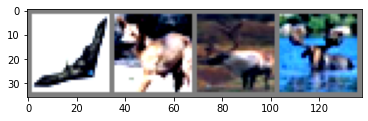

In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(loader10.train_loader_Alb)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = resnet.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



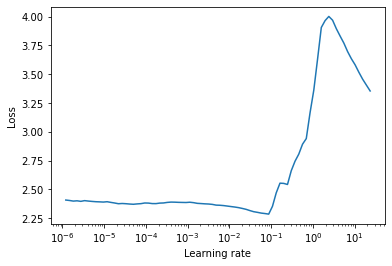

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(loader10.train_loader, end_lr=100, num_iter=100, step_mode="exp")                                
lr_finder.plot() 
#lr_finder.reset()                                                                                                                                              

In [8]:
Best_lr=lr_finder.history['lr'][lr_finder.history['loss'].index(min(lr_finder.history['loss']))]

In [10]:
lr_finder.reset()

In [9]:
Best_lr

0.08709635899560812

In [11]:
model =  resnet.ResNet18().to(device)
optimizer = optim.SGD(model.parameters(), Best_lr, momentum=0.9, weight_decay=0.0001) 
scheduler = ReduceLROnPlateau(optimizer, patience = 3 , min_lr=1e-4)
loss_func=nn.CrossEntropyLoss()
 
for epoch in range(35):
    print("Epoch:", epoch)
    train10.train(model, device, loader10.train_loader_Albumentation, optimizer, loss_func, epoch)
    # scheduler.step()
    test10.test(model, device, loader10.test_loader,loss_func,last_epoch=True)
    print("lr :" ,)
    scheduler.step(test10.test_losses[-1])

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0


Epoch= 0 Loss=1.8287291526794434 Batch_id=781 Accuracy=33.08: 100%|██████████| 782/782 [01:06<00:00, 11.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 4562/10000 (45.62%)

lr :
Epoch: 1


Epoch= 1 Loss=1.1759626865386963 Batch_id=781 Accuracy=49.37: 100%|██████████| 782/782 [01:06<00:00, 11.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 5191/10000 (51.91%)

lr :
Epoch: 2


Epoch= 2 Loss=1.848670482635498 Batch_id=781 Accuracy=58.56: 100%|██████████| 782/782 [01:06<00:00, 11.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 6001/10000 (60.01%)

lr :
Epoch: 3


Epoch= 3 Loss=0.8474984765052795 Batch_id=781 Accuracy=65.18: 100%|██████████| 782/782 [01:06<00:00, 11.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 6429/10000 (64.29%)

lr :
Epoch: 4


Epoch= 4 Loss=0.9144563674926758 Batch_id=781 Accuracy=69.31: 100%|██████████| 782/782 [01:06<00:00, 11.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0123, Accuracy: 7218/10000 (72.18%)

lr :
Epoch: 5


Epoch= 5 Loss=0.8975412845611572 Batch_id=781 Accuracy=72.57: 100%|██████████| 782/782 [01:06<00:00, 11.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0144, Accuracy: 6814/10000 (68.14%)

lr :
Epoch: 6


Epoch= 6 Loss=1.2035983800888062 Batch_id=781 Accuracy=75.64: 100%|██████████| 782/782 [01:06<00:00, 11.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0116, Accuracy: 7400/10000 (74.00%)

lr :
Epoch: 7


Epoch= 7 Loss=0.22329998016357422 Batch_id=781 Accuracy=77.84: 100%|██████████| 782/782 [01:06<00:00, 11.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0096, Accuracy: 7896/10000 (78.96%)

lr :
Epoch: 8


Epoch= 8 Loss=0.805271565914154 Batch_id=781 Accuracy=80.12: 100%|██████████| 782/782 [01:06<00:00, 11.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0109, Accuracy: 7693/10000 (76.93%)

lr :
Epoch: 9


Epoch= 9 Loss=0.4205213189125061 Batch_id=781 Accuracy=82.21: 100%|██████████| 782/782 [01:06<00:00, 11.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0092, Accuracy: 8033/10000 (80.33%)

lr :
Epoch: 10


Epoch= 10 Loss=0.4700961709022522 Batch_id=781 Accuracy=83.71: 100%|██████████| 782/782 [01:06<00:00, 11.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 8101/10000 (81.01%)

lr :
Epoch: 11


Epoch= 11 Loss=1.2950992584228516 Batch_id=781 Accuracy=84.77: 100%|██████████| 782/782 [01:06<00:00, 11.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0085, Accuracy: 8139/10000 (81.39%)

lr :
Epoch: 12


Epoch= 12 Loss=0.22191929817199707 Batch_id=781 Accuracy=86.12: 100%|██████████| 782/782 [01:06<00:00, 11.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 8099/10000 (80.99%)

lr :
Epoch: 13


Epoch= 13 Loss=0.1490134298801422 Batch_id=781 Accuracy=86.94: 100%|██████████| 782/782 [01:06<00:00, 11.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 8171/10000 (81.71%)

lr :
Epoch: 14


Epoch= 14 Loss=0.23668012022972107 Batch_id=781 Accuracy=87.36: 100%|██████████| 782/782 [01:06<00:00, 11.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 8155/10000 (81.55%)

lr :
Epoch: 15


Epoch= 15 Loss=0.5637348294258118 Batch_id=781 Accuracy=88.31: 100%|██████████| 782/782 [01:06<00:00, 11.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 8515/10000 (85.15%)

lr :
Epoch: 16


Epoch= 16 Loss=0.19472502171993256 Batch_id=781 Accuracy=88.77: 100%|██████████| 782/782 [01:06<00:00, 11.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 8430/10000 (84.30%)

lr :
Epoch: 17


Epoch= 17 Loss=0.3806467652320862 Batch_id=781 Accuracy=89.41: 100%|██████████| 782/782 [01:06<00:00, 11.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 8353/10000 (83.53%)

lr :
Epoch: 18


Epoch= 18 Loss=0.29719799757003784 Batch_id=781 Accuracy=89.75: 100%|██████████| 782/782 [01:06<00:00, 11.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 8372/10000 (83.72%)

lr :
Epoch: 19


Epoch= 19 Loss=0.6642876863479614 Batch_id=781 Accuracy=90.37: 100%|██████████| 782/782 [01:06<00:00, 11.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0079, Accuracy: 8397/10000 (83.97%)

lr :
Epoch: 20


Epoch= 20 Loss=0.045729804784059525 Batch_id=781 Accuracy=94.72: 100%|██████████| 782/782 [01:06<00:00, 11.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 8792/10000 (87.92%)

lr :
Epoch: 21


Epoch= 21 Loss=0.07623773068189621 Batch_id=781 Accuracy=96.27: 100%|██████████| 782/782 [01:06<00:00, 11.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 8801/10000 (88.01%)

lr :
Epoch: 22


Epoch= 22 Loss=0.15700149536132812 Batch_id=781 Accuracy=96.77: 100%|██████████| 782/782 [01:06<00:00, 11.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 8837/10000 (88.37%)

lr :
Epoch: 23


Epoch= 23 Loss=0.044438835233449936 Batch_id=781 Accuracy=97.05: 100%|██████████| 782/782 [01:06<00:00, 11.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 8844/10000 (88.44%)

lr :
Epoch: 24


Epoch= 24 Loss=0.14462678134441376 Batch_id=781 Accuracy=97.35: 100%|██████████| 782/782 [01:06<00:00, 11.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8868/10000 (88.68%)

lr :
Epoch: 25


Epoch= 25 Loss=0.32294657826423645 Batch_id=781 Accuracy=97.65: 100%|██████████| 782/782 [01:06<00:00, 11.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 8868/10000 (88.68%)

lr :
Epoch: 26


Epoch= 26 Loss=0.20849603414535522 Batch_id=781 Accuracy=97.88: 100%|██████████| 782/782 [01:06<00:00, 11.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 8883/10000 (88.83%)

lr :
Epoch: 27


Epoch= 27 Loss=0.3222692906856537 Batch_id=781 Accuracy=97.90: 100%|██████████| 782/782 [01:06<00:00, 11.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 8907/10000 (89.07%)

lr :
Epoch: 28


Epoch= 28 Loss=0.02240743488073349 Batch_id=781 Accuracy=97.89: 100%|██████████| 782/782 [01:06<00:00, 11.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 8876/10000 (88.76%)

lr :
Epoch: 29


Epoch= 29 Loss=0.09768197685480118 Batch_id=781 Accuracy=97.88: 100%|██████████| 782/782 [01:06<00:00, 11.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 8888/10000 (88.88%)

lr :
Epoch: 30


Epoch= 30 Loss=0.056456126272678375 Batch_id=781 Accuracy=97.97: 100%|██████████| 782/782 [01:06<00:00, 11.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 8885/10000 (88.85%)

lr :
Epoch: 31


Epoch= 31 Loss=0.07244135439395905 Batch_id=781 Accuracy=97.84: 100%|██████████| 782/782 [01:06<00:00, 11.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 8871/10000 (88.71%)

lr :
Epoch: 32


Epoch= 32 Loss=0.0024704565294086933 Batch_id=781 Accuracy=97.95: 100%|██████████| 782/782 [01:06<00:00, 11.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 8883/10000 (88.83%)

lr :
Epoch: 33


Epoch= 33 Loss=0.0793796181678772 Batch_id=781 Accuracy=97.96: 100%|██████████| 782/782 [01:06<00:00, 11.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 8901/10000 (89.01%)

lr :
Epoch: 34


Epoch= 34 Loss=0.19468696415424347 Batch_id=781 Accuracy=97.97: 100%|██████████| 782/782 [01:06<00:00, 11.78it/s]



Test set: Average loss: 0.0061, Accuracy: 8893/10000 (88.93%)

lr :


Text(0.5, 1.0, 'Test Accuracy')

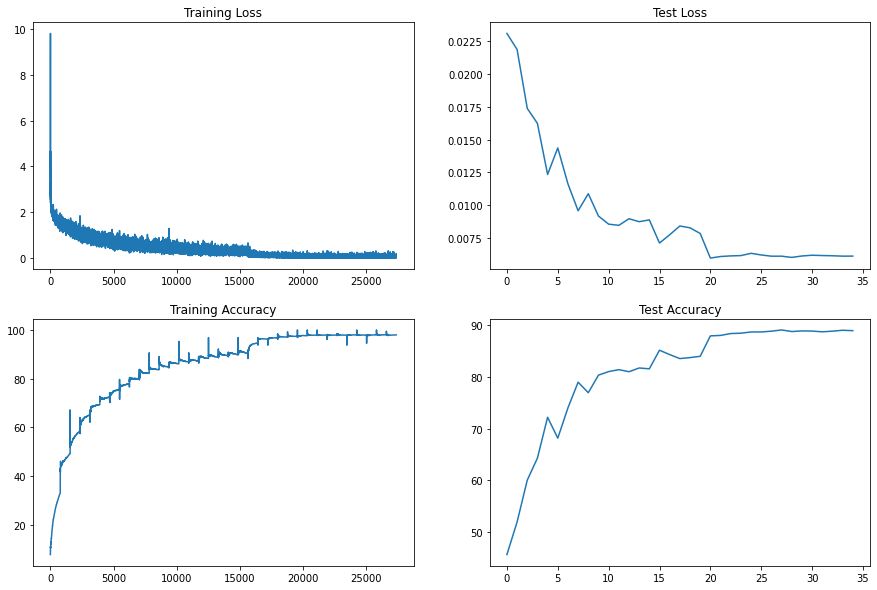

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train10.train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train10.train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test10.test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test10.test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
import warnings
warnings.filterwarnings("ignore")
target_layers = ["layer1","layer2","layer3","layer4"]  
grad_cam = GradCAMView(model ,classes,target_layers )  

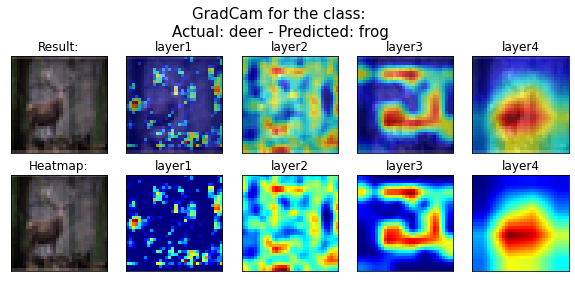

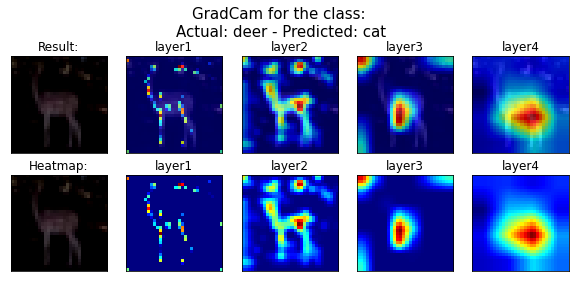

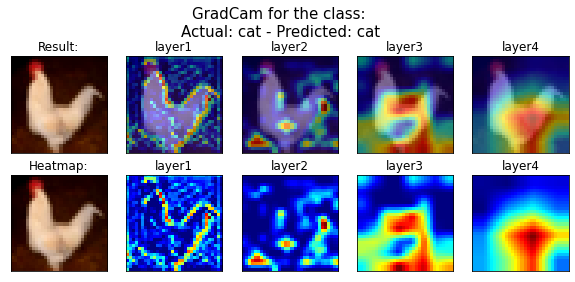

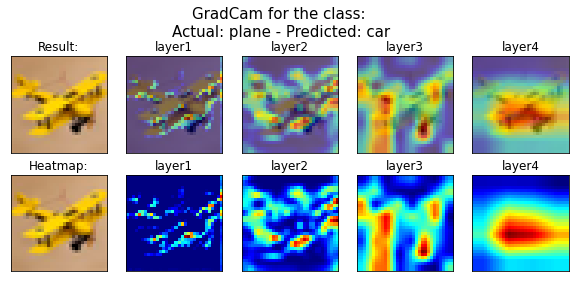

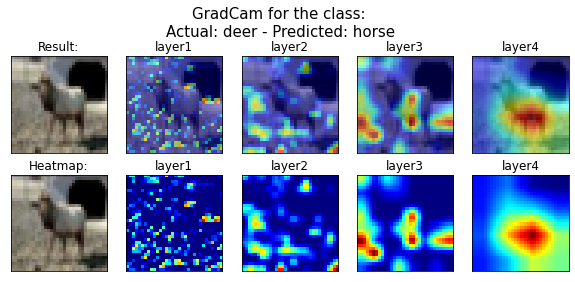

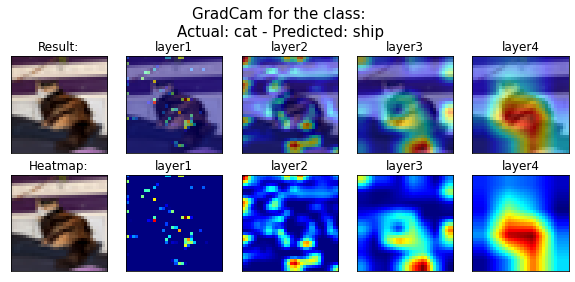

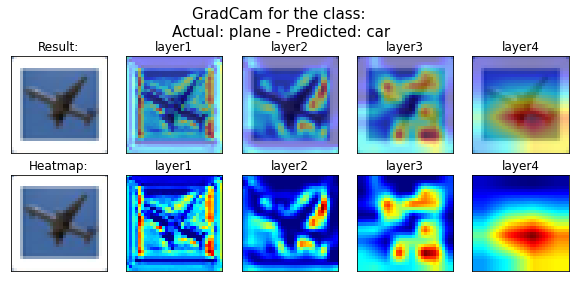

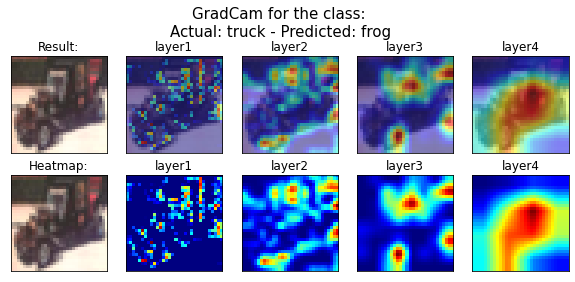

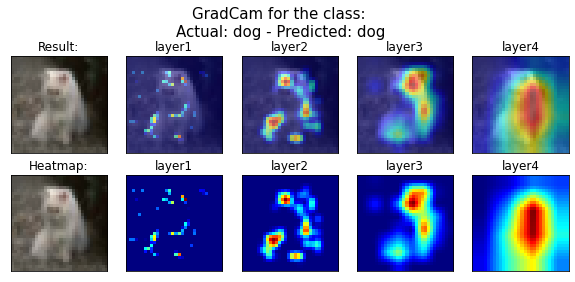

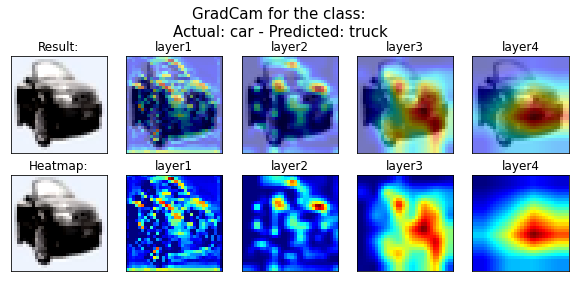

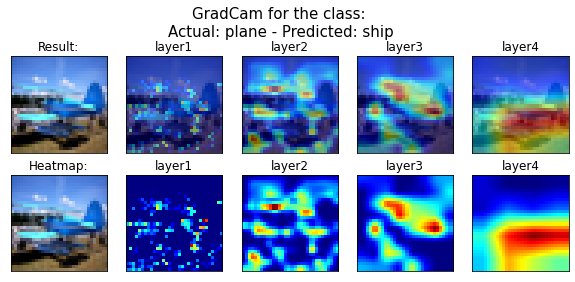

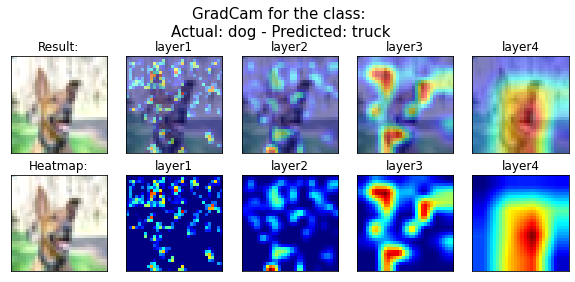

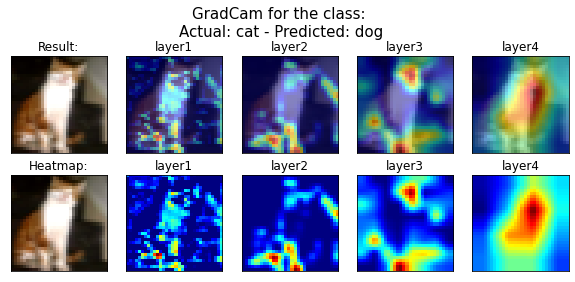

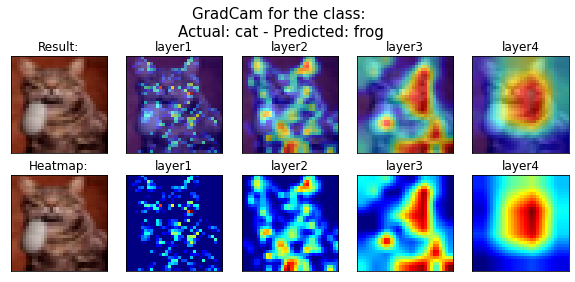

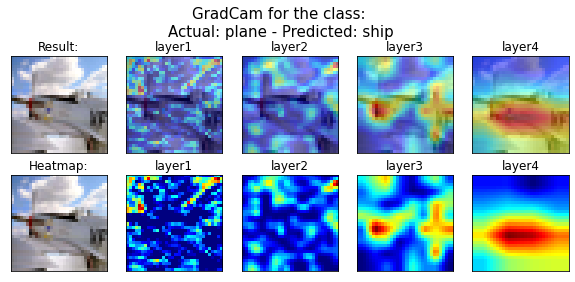

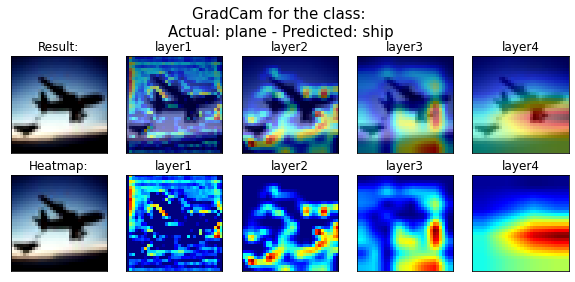

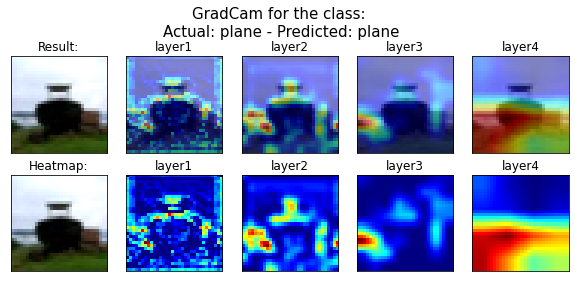

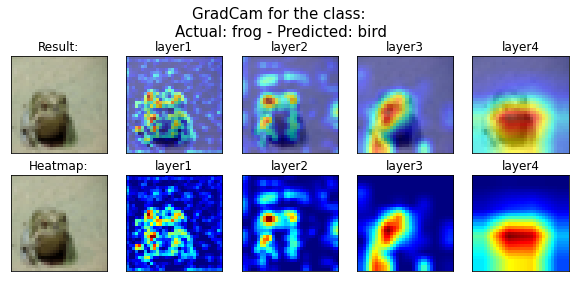

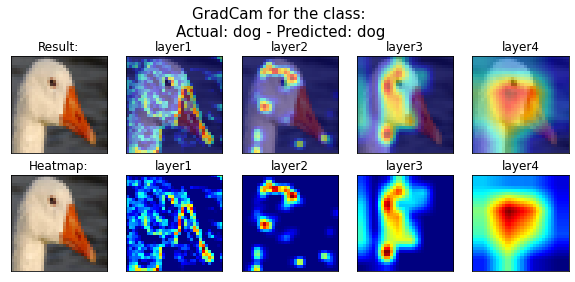

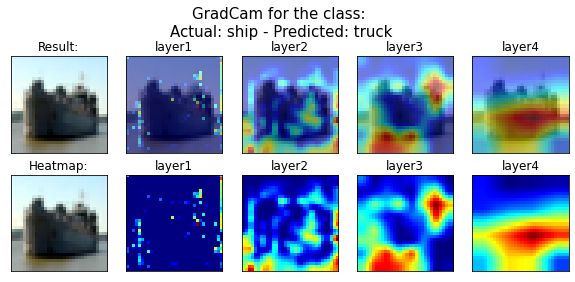

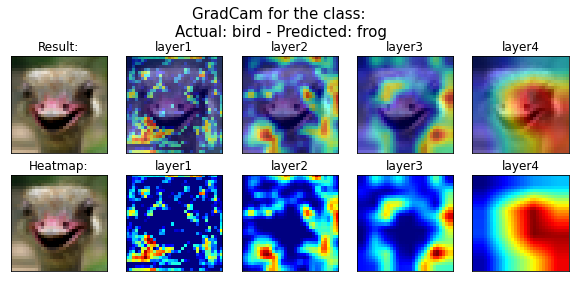

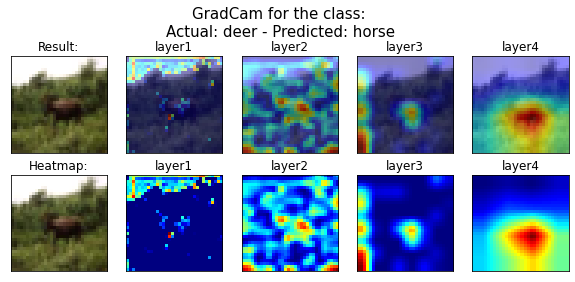

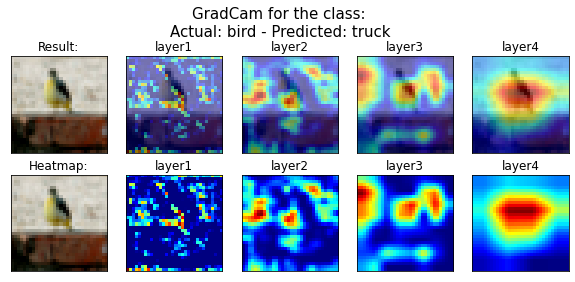

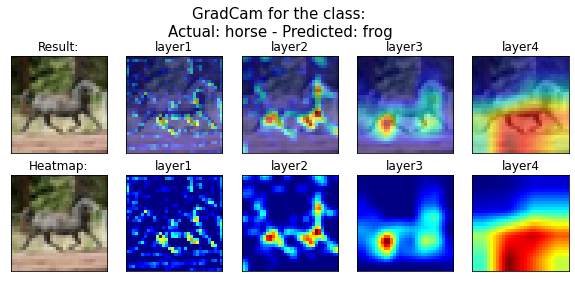

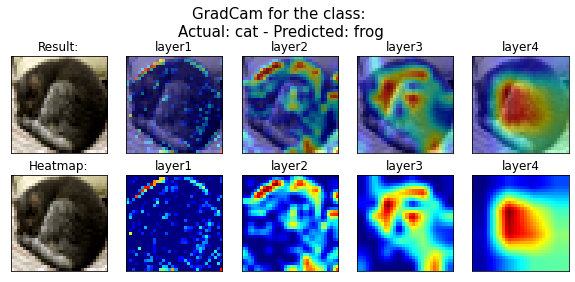

In [ ]:
num_img = 25
incorrect_pred_imgs = []
truth_image = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(test10.incorrect_pred[i]["image"]))
  truth_image.append(test10.incorrect_pred[i]["prediction"])
grad_cam(torch.stack(incorrect_pred_imgs), truth_image, target_layers, metric="incorrect",per_image=True)